In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import scipy
import sys
import os
from time import time
np.random.seed(1234567)

sys.path.append('../')
sys.path.append('../../')
sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
import processing.preprocessfft as preprocess
import processing.frequencytransform as ft
import processing.util as util

sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
import fragility.util.utils as futil
import datainterface
from datainterface import patient as Pat


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ntpath
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Convert Data

Data will be stored either as edf files, or .eeg files. We can use our eegreader to read .eeg files (if no bugs) and pyedflib to read the .edf files.

Then, we want to make sure we have the vital information regarding each dataset.

In [9]:
filename = '/Users/adam2392/Downloads/tngrawdata/id001_ac/crise1/crise cabrol.eeg'
eegreader = datainterface.read_eeg.EEG(filename)


reading header from <open file '/Users/adam2392/Downloads/tngrawdata/id001_ac/crise1/crise cabrol.eeg', mode 'rb' at 0x113dc8f60>


IOError: <open file '/Users/adam2392/Downloads/tngrawdata/id001_ac/crise1/crise cabrol.eeg', mode 'rb' at 0x113dc8f60> is not a valid EEG file

In [2]:
#### 1. first run data conversion
patient = 'id001_ac'
outputdir = os.path.join('/Volumes/ADAM LI/pydata/convertedtng/', patient)
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

edfdir = os.path.join('/Users/adam2392/Downloads/tngrawdata/', patient)
edffile = os.path.join(edfdir, '')
edffile ='/Users/adam2392/Downloads/tngrawdata/id001_ac/crise2/crise_fin/091126B-BEX_0006.edf'

In [3]:
#### 1. setting filename 
npyfile = os.path.join(outputdir,  patient.lower() + '_rawnpy.npy')
chanfile =  os.path.join(outputdir,  patient.lower() + '_chans.csv')
headerfile = os.path.join(outputdir,  patient.lower() + '_headers.csv')
annotationsfile = os.path.join(outputdir, patient.lower() + '_annotations.csv')

# convert data into csv files and numpy raw data file
converter = datainterface.dataconversion.EDFConverter(edffile)
converter.edfrawtonumpy(npyfile)
converter.edfmetatocsv(headerfile, \
                    chanfile, \
                    annotationsfile)
f1=open(os.path.join(outputdir, 'datadescrip.txt'), 'w+')
f1.write(edffile)
f1.close()

AttributeError: module 'datainterface' has no attribute 'dataconversion'

# 1. Run FFT Analysis 

In [82]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def extractrawdata(patient, datadir, fileend=None):
    '''
    This function takes in:
    1. patient name
    2. results directory (perturbation model)
    3. data directory, where all the raw metadata is held
    
    And extracts the data necessary for plotting
    '''
    # files to get resulting data and the original raw data / annotations
    rawdatafile = os.path.join(datadir,  patient + fileend, patient+'_rawnpy.npy')
    chanfile =  os.path.join(datadir,  patient + fileend, patient + '_chans.csv')
    headerfile = os.path.join(datadir,  patient + fileend, patient + '_headers.csv')
    annotationsfile = os.path.join(datadir,  patient + fileend, patient + '_annotations.csv')

    ################################ 1. LOAD DATA ###########################
    # instantiate a datainterface object to analyze data
    patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
    # get relevant channel data
    patid, seizid = futil.splitpatient(patient)
    included_chans, onsetchans, clinresult = fragility.util.utils.returnindices(patid, seizid)
    
    # set metadata to be used in analysis
    patieeg.setincludedchans(included_chans)
    patieeg.setmetadata_fromfile(headersfile=headerfile)
    patieeg.setchannels_fromfile(channelsfile=chanfile)
    patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

    # get the data from files
    data = np.load(rawdatafile)
    
    return patieeg, data, included_chans, onsetchans

In [3]:
expname = 'id001_ac'
traindir = os.path.join('/Volumes/ADAM LI/pydata/dnn/testdata/fft/', 
                        expname)
if not os.path.exists(traindir):
    os.makedirs(traindir)

# establish frequency bands
freqbands = {
        'dalpha':[0,15],
        'beta':[15,30],
        'gamma':[30,90],
        'high':[90,200],
    }
postprocessfft = preprocess.PreProcess(freqbands=freqbands)
# FFT Parameters
fs = 500
winsize = 1000 # winsize in milliseconds
stepsize = 500 # stepsize in milliseconds
typetransform = 'fourier'
mtbandwidth = 4
mtfreqs = []

mtaper = ft.MultiTaperFFT(winsize, stepsize, fs, mtbandwidth, mtfreqs)

print(traindir)

Default method of tapering is eigen
/Volumes/ADAM LI/pydata/dnn/testdata/fft/id001_ac


In [41]:
datadir = '/Volumes/ADAM LI/pydata/convertedtng/'
patient='id001_ac'
# load in the data for a real patient
patieeg, rawdata, included_chans, onsetchans = extractrawdata(patient, datadir, '_sz2')

rawdata=rawdata.T
print(patieeg)
print(rawdata.shape)
print(included_chans.shape)
print(onsetchans)

INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


(84, 306688)
(0,)
None


In [77]:
metadatadir = os.path.join('/Volumes/ADAM LI/pydata/metadata/', patient)  
# load in seegxyz
seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
chanlabels = seeg.index
seeg_xyz = seeg.as_matrix() 

allchans = patieeg.chanlabels
chanindices = [i for i, x in enumerate(allchans) if any(thing == x for thing in chanlabels)]

rawdata = rawdata[chanindices,:]

print(rawdata.shape)

(70, 306688)


In [78]:
# run FFT analysis
mtaper.loadrawdata(rawdata)
power, freqs, timepoints, _ = mtaper.mtwelch()
power = postprocessfft.binFrequencyValues(power, freqs)

Loaded raw data in MultiTaperFFT!


../processing/preprocessfft.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  power_binned[:,idx,:] = np.mean(power[:,indices[0]:indices[1]+1,:], axis=1) #[np.newaxis,:,:]


In [100]:
onsettime = patieeg.onset_time
offsettime = patieeg.offset_time
# fs = patieeg.samplefreq
# get seiztimes given onset/offset
# if onsettime: 
#     onset_indice = fragility.util.utils.converttimestowindow(timepoints, onsettime*fs)
# if offsettime:
#     offset_indice = fragility.util.utils.converttimestowindow(timepoints, offsettime*fs)
# seiztimes = zip(onset_indice, offset_indice)
# print(seiztimes)
filename = os.path.join(traindir, 
                        patient + '_fft.npz')

np.savez_compressed(filename, 
                    power=power, 
                    timepoints=timepoints,
                    seizonsets=np.array([onsettime*fs]),
                    seizoffsets=np.array([offsettime*fs]),
                    locs=seeg_xyz,
                    seeg_contacts=chanlabels)
print(filename)
print(power.shape)
print(freqs.shape)
print(timepoints.shape)
print('\n\n')

/Volumes/ADAM LI/pydata/dnn/testdata/fft/id001_ac/id001_ac_fft.npz
(70, 4, 1225)
(251,)
(1225, 2)





In [52]:
print(offsettime)
print(offsettime.size)
print(timepoints.shape)

print(np.where(np.logical_and(timepoints[:,0] < offsettime*fs, timepoints[:,1] > offsettime*fs))[0][0])
# print(np.where(timepoints[:,1] > offsettime)[0])
# print(np.where(timepoints[:,0] < offsettime))

532.7539062
1
(1225, 2)
1064


# 2. Run Image Creation for 2D Mesh

In [4]:
expname = 'id001_ac'
datadir = os.path.join('/Volumes/ADAM LI/pydata/dnn/testdata/fft/', expname) 

# load in meta data
confile = os.path.join(metadatadir, "connectivity.zip")

# get the regions, and region_centers from connectivity
# reader = util.ZipReader(confile)
# region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
# regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))

# fftdatafile, seeg contacts, 
datafile = os.path.join(datadir, patient+'_fft.npz')

NameError: name 'metadatadir' is not defined

In [6]:
# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/dnn/testdata/image_2d/', expname)
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)
    
# loop through each data file and get grid
data = np.load(datafile, encoding='bytes')
power = data['power']
print(power.shape)
print(data.keys())

# load xyz data for this particular dataset
xyz_data = data['locs']
seeg_contacts = data['seeg_contacts']
seizonsets = data['seizonsets']
seizoffsets = data['seizoffsets']
timepoints = data['timepoints']

# project xyz data
new_locs = pca.fit_transform(xyz_data)

print(seizonsets)
print(seizoffsets)
ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)

if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
    print("skipping ", datafile)
else:
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(new_locs, power, 
                            n_gridpoints=32, normalize=True, augment=False, 
                            pca=False, std_mult=0.1, edgeless=False)

print(image_tensor.shape)
# set saving file paths for image and corresponding meta data
filename = path_leaf(datafile)
imagefilename = os.path.join(trainimagedir, filename)

# instantiate metadata hash table
metadata = dict()
metadata['seeg_contacts'] = seeg_contacts
metadata['new_locs'] = new_locs
metadata['ylabels'] = ylabels

# save image and meta data
np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)

print(new_locs.shape)

NameError: name 'datafile' is not defined

In [60]:
print(xyz_data.shape)
print(new_locs.shape)
print(power.shape)

(70, 3)
(70, 2)
(84, 4, 1225)


[85876.9531]
[266376.9531]
342 1064
Baseline testing prediction of all seizure:  0.5893877551020408


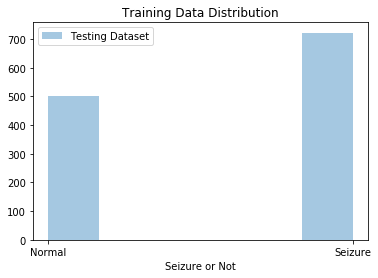

In [104]:
print(seizonsets)
print(seizoffsets)
ydata = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
plt.figure()
sns.distplot(ydata, kde=False, axlabel='Seizure or Not', label='Testing Dataset')
ax=plt.gca()
ax.set_title('Training Data Distribution')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal', 'Seizure'])
ax.legend()

print("Baseline testing prediction of all seizure: ", np.sum(ydata)/len(ydata))

In [113]:
images = image_tensor.swapaxes(1,3)
print(images.shape)

avg = np.mean(images.reshape((-1,4)), axis=0, keepdims=True)
std = np.std(images.reshape((-1,4)), axis=0, keepdims=True)
print(avg.shape)

def normalizeimage(imagetensor):
    # assumes imagetensor shape is [nsamps, width, height, nchans]
    temptensor = imagetensor.reshape((-1, 4))
    
    # get average/std and store temporary
    avg = np.mean(temptensor, axis=0, keepdims=True)
    std = np.std(temptensor, axis=0, keepdims=True)
    
    temptensor = np.subtract(temptensor, avg)
    temptensor = np.divide(temptensor,std)
    print(temptensor.shape)
    imagetensor = temptensor.reshape((-1, 32, 32, 4))
    return imagetensor

test = normalizeimage(images)
print(test.shape)

(1225, 32, 32, 4)
(1, 4)
(1254400, 4)
(1225, 32, 32, 4)


In [8]:
imagefilename = os.path.join(trainimagedir, 'id001_ac_fft.npz')
print(imagefilename)
data = np.load(imagefilename)
print(data.keys())

/Volumes/ADAM LI/pydata/dnn/testdata/image_2d/id001_ac/id001_ac_fft.npz
['image_tensor', 'metadata']
